# Weather Type

The purpose of this notebook is to plot the circulation patterns associated with the various weather types and the time series of weather types

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import calendar
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature
import paraguayfloodspy.visualize as viz # custom plotting library
import matplotlib.patches as patches
%matplotlib inline

Load in configuration parameters from file

In [3]:
%run ../config/WeatherTypes.mk
print(WTEAST, WTWEST, WTSOUTH, WTNORTH)

315 295 -30 -15


Define the extents to use for these plots and get some consistent color schemes

In [5]:
savefigs = True
rain_extent = [275, 330, 5, -45]
my_extent = [-110,-20,-60,10]
cmap_streamfunc = 'PuOr'
cmap_streamfunc_a = 'PuOr'
cmap_rain = 'Greens'
cmap_raina = 'BrBG'

Read in raw data

In [6]:
psi = xr.open_dataset('../data/derived/psi_850.nc')
prcp = xr.open_dataset('../data/derived/precip.nc')
wtypes = pd.read_csv("../data/derived/WeatherTypes.csv", index_col='time', parse_dates=True)

Get the X and Y coordinates for plotting

In [7]:
X, Y = np.meshgrid(psi.lon, psi.lat)
Xp, Yp = np.meshgrid(prcp.lon, prcp.lat)

Print out the climatological probability of each weather type

In [13]:
wt_counts = wtypes.groupby('wtype').size()
wt_counts2 = wtypes['2015-11-01':'2016-02-29'].groupby('wtype').size()
wt_prop = pd.DataFrame({'climatology': wt_counts / np.sum(wt_counts), 
              'NDJF1516': wt_counts2 / np.sum(wt_counts2)})

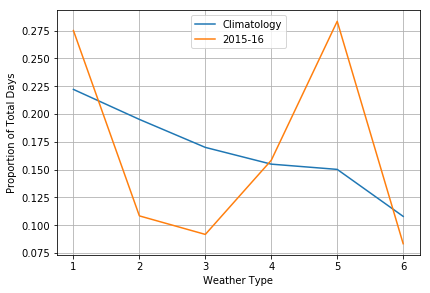

In [14]:
plt.figure(figsize=(6.5, 4.5))
plt.plot(wt_prop['climatology'], label = "Climatology")
plt.plot(wt_prop['NDJF1516'], label = "2015-16")
plt.xlabel("Weather Type")
plt.ylabel("Proportion of Total Days")
plt.legend()
plt.grid()
if savefigs:
    plt.savefig("../figs/WT_Occurrence_Proportion.pdf")

In [16]:
wt_prop

,NDJF1516,climatology
wtype,,
1,0.275000,0.222072
2,0.108333,0.195100
3,0.091667,0.169926
4,0.158333,0.154866
5,0.283333,0.150146
6,0.083333,0.107889


Repeat for NDJF 2015-16

## Composites

In [21]:
wt_all = np.unique(wtypes['wtype'])
ncols = len(wt_all)

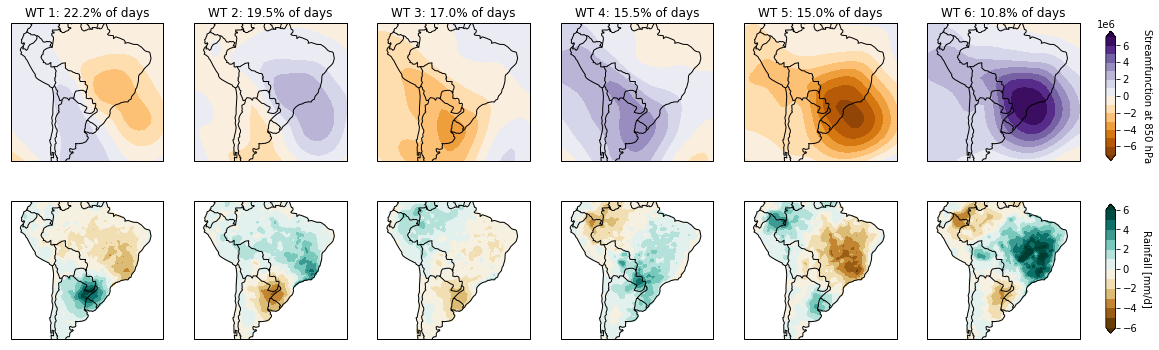

In [22]:
fig, axes = viz.SetupAxes(ncol = ncols, nax = 2 * ncols, proj = ccrs.Orthographic(-60, -10), figsize = [18, 6])
fig.subplots_adjust(right=0.95)
cax1 = fig.add_axes([0.97, 0.55, 0.0075, 0.3])
cax2 = fig.add_axes([0.97, 0.15, 0.0075, 0.3])
for i,wt in enumerate(wt_all):
    def selector(ds, wt):
        times = wtypes.loc[wtypes['wtype'] == wt].index
        ds = ds.sel(time = np.in1d(ds.time, times))
        ds = ds.mean(dim = 'time')
        return(ds)

    # Row 1: 850 hPa wind
    ax = axes[0, i]
    ax.set_title('WT {}: {:.1%} of days'.format(wt, wt_prop['climatology'].values[i]))
    C1 = ax.contourf(X, Y, selector(psi['anomaly'], wt=wt), transform = ccrs.PlateCarree(), 
                     cmap = cmap_streamfunc_a, extend="both", levels=np.linspace(-7e6, 7e6, 15))
    # Indicate WT Region
    ax.add_patch(
            patches.Rectangle((-65, -30), 20,15, #X,Y,dX,dY
                color = 'black', fill = None, linewidth=2, alpha=1))
    
    # Row 2: Rainfall
    ax = axes[1, i]
    sub = selector(prcp['anomaly'], wt=wt).values
    sub = np.ma.masked_invalid(sub)
    C2 = ax.contourf(Xp, Yp, sub, transform = ccrs.PlateCarree(), 
                     cmap = cmap_raina, levels=np.linspace(-6, 6, 13), extend='both')

# Colorbars for Reanalysis Data
cbar1 = fig.colorbar(C1, cax = cax1)
cbar1.formatter.set_powerlimits((7, 7))
cbar1.update_ticks()
cbar1.set_label(r'Streamfunction at 850 hPa', rotation=270)
cbar1.ax.get_yaxis().labelpad = 15

# Colorbar for Rainfall
cbar2 = fig.colorbar(C2, cax=cax2)
cbar2.set_label(r'Rainfall [mm/d]', rotation=270)
cbar2.ax.get_yaxis().labelpad = 15

# Coasts and Countries
viz.FormatAxes(axes[0,:], coast=True, grid=False, border=True, river = False,
               feature_list = [], states=False, extent = rain_extent, ticks=None)
viz.FormatAxes(axes[1,:], coast=True, grid=False, border=True, river = False,
               feature_list = [], states=False, extent = rain_extent, ticks=None)

if savefigs:
    fig.savefig("../figs/WTComposite.pdf", bbox_inches='tight')

## Time Series

In [33]:
prcp_rpy = pd.read_csv("../data/derived/rainfall_rpy.csv", index_col='time')[['raw']]
prcp_rpy_sub = prcp_rpy['2015-11-01':'2016-02-29']

In [34]:
wtypes_sub = wtypes['2015-11-01':'2016-02-29']
wt_prcp = prcp_rpy_sub.join(wtypes_sub)
wt_prcp.head()

,raw,wtype
time,,
2015-11-01,0.003657,6
2015-11-02,0.713011,2
2015-11-03,2.819442,4
2015-11-04,16.780805,1
2015-11-05,6.319572,3


In [35]:
plt.style.use('ggplot')

/usr/local/miniconda3/envs/pyfloods/lib/python3.6/site-packages/numpy/lib/function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


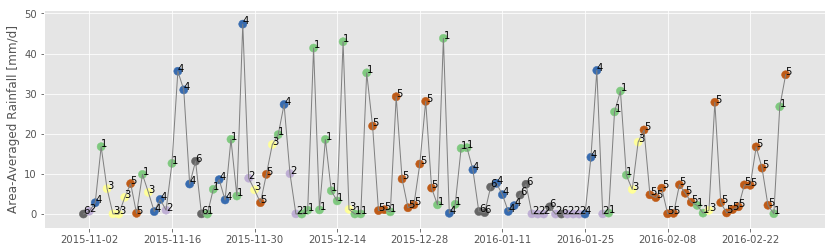

In [39]:
cmap = plt.get_cmap('Accent', 6)
fig = plt.figure(figsize=(14,4))
plt.plot(wt_prcp.index, wt_prcp['raw'], color='gray', linewidth=1)
plt.axhline(np.percentile(prcp_rpy, 50), label="p50", color='blue', linestyle='--', linewidth=0.75)
plt.axhline(np.percentile(prcp_rpy, 90), label="p90", color='blue', linestyle='--', linewidth=0.75)
plt.axhline(np.percentile(prcp_rpy, 99), label="p99", color='blue', linestyle='--', linewidth=0.75)
plt.scatter(wt_prcp.index, wt_prcp['raw'], c=wt_prcp['wtype'], cmap=cmap, s=65)
plt.ylabel('Area-Averaged Rainfall [mm/d]')
for i,t in enumerate(wt_prcp.index):
    plt.text(t, wt_prcp.iloc[i]['raw'], '{:d}'.format(np.int(wt_prcp.iloc[i]['wtype'])))
if savefigs:
    fig.savefig("../figs/RainfallWeatherType.pdf", bbox_inches='tight')